In [1]:
# Hidden cell, contains initialization code
import numpy as np
import xarray as xr
import eradiate

from eradiate.pipelines.engine import Pipeline

eradiate.notebook.install()

In [2]:
pipeline = (
    Pipeline()
    .add_node("a", lambda: 10, description="Constant 10")
    .add_node("b", lambda: 20, description="Constant 20")
    .add_node("sum", lambda a, b: a + b, dependencies=["a", "b"])
    .add_node("product", lambda a, b: a * b, dependencies=["a", "b"])
)

# Only nodes in the dependency chain of the requested outputs are executed
pipeline.execute(outputs=["sum", "product"])

{'sum': 30, 'product': 200}

In [3]:
pipeline = Pipeline()
pipeline.add_node("scaled", lambda raw: raw * 2, dependencies=["raw"])
pipeline.add_node("shifted", lambda scaled: scaled + 1, dependencies=["scaled"])

print("Virtual inputs:", pipeline.get_virtual_inputs())

pipeline.execute(outputs=["shifted"], inputs={"raw": np.array([1.0, 2.0, 3.0])})

Virtual inputs: ['raw']


{'shifted': array([3., 5., 7.])}

In [4]:
pipeline.get_required_inputs(outputs=["shifted"])

['raw']

In [5]:
pipeline = Pipeline()

def expensive_computation():
    print("  [running expensive computation]")
    return np.array([1, 2, 3, 4, 5])

pipeline.add_node("expensive", expensive_computation)
pipeline.add_node("processed", lambda expensive: expensive * 2, dependencies=["expensive"])
pipeline.add_node("final", lambda processed: processed + 10, dependencies=["processed"])

print("Normal execution:")
r1 = pipeline.execute(outputs=["final"])
print("Result:", r1["final"])

print("\nBypassed (expensive node skipped):")
r2 = pipeline.execute(outputs=["final"], inputs={"expensive": np.array([10, 20, 30, 40, 50])})
print("Result:", r2["final"])

Normal execution:
  [running expensive computation]
Result: [12 14 16 18 20]

Bypassed (expensive node skipped):
Result: [ 30  50  70  90 110]


In [6]:
def build_pipeline(mode: str) -> Pipeline:
    pipeline = Pipeline()
    pipeline.add_node("data", lambda: np.array([1, 2, 3, 4, 5]))

    if mode == "simple":
        pipeline.add_node("result", lambda data: data * 2, dependencies=["data"])
    else:
        pipeline.add_node("intermediate", lambda data: data * 2, dependencies=["data"])
        pipeline.add_node("result", lambda intermediate: intermediate + 10, dependencies=["intermediate"])

    return pipeline


for mode in ["simple", "ckd"]:
    result = build_pipeline(mode).execute(outputs=["result"])
    print(f"{mode}: {result['result']}")

simple: [ 2  4  6  8 10]
ckd: [12 14 16 18 20]


In [7]:
def validate_type(t):
    def validate_type_impl(x):
        print("Validating type ...")
        if not isinstance(x, t):
            raise TypeError("wrong type")
    return validate_type_impl

pipeline = Pipeline()
pipeline.add_node(
    "raw",
    lambda: xr.DataArray(np.abs(np.random.randn(3, 4)), dims=["x", "y"]),
    post_funcs=[validate_type(xr.DataArray)],
).add_node(
    "normalized",
    lambda raw: (raw - raw.mean()) / raw.std(),
    dependencies=["raw"],
)

results = pipeline.execute(outputs=["normalized"])
print(f"Shape: {results['normalized'].shape}, mean ≈ {float(results['normalized'].mean()):.2e}")

Validating type ...
Shape: (3, 4), mean ≈ -8.67e-19


In [8]:
def compute_statistics(data):
    return {
        "mean": float(data.mean()),
        "std": float(data.std()),
    }

pipeline = (
    Pipeline()
    .add_node("data", lambda: np.arange(10, dtype=float))
    .add_node("_stats", compute_statistics, dependencies=["data"], outputs=["mean", "std"])
    .add_node("cv", lambda mean, std: std / mean, dependencies=["mean", "std"])
)

pipeline.execute(outputs=["mean", "std", "cv"])

{'mean': 4.5, 'std': 2.8722813232690143, 'cv': 0.6382847385042254}

In [9]:
def build_pipeline(compute_ratio: bool) -> Pipeline:
    pipeline = Pipeline()
    pipeline.add_node("data", lambda: np.array([1.0, 4.0, 9.0, 16.0]))
    pipeline.add_node(
        "sqrt_data", lambda data: np.sqrt(data), dependencies=["data"],
        metadata={"final": True, "kind": "data"},
    )
    pipeline.add_node(
        "log_data", lambda data: np.log(data), dependencies=["data"],
        metadata={"final": True, "kind": "data"},
    )
    if compute_ratio:
        pipeline.add_node(
            "ratio",
            lambda sqrt_data, log_data: sqrt_data / log_data,
            dependencies=["sqrt_data", "log_data"],
            metadata={"final": True, "kind": "data"},
        )
    return pipeline


for flag in [False, True]:
    p = build_pipeline(compute_ratio=flag)
    outputs = p.get_nodes_by_metadata(final=True, kind="data")
    results = p.execute(outputs=outputs)
    print(f"compute_ratio={flag}  →  outputs: {list(results.keys())}")

compute_ratio=False  →  outputs: ['sqrt_data', 'log_data']
compute_ratio=True  →  outputs: ['sqrt_data', 'log_data', 'ratio']


/var/folders/bz/9bdxq9q50tx190wd4g1xc1xc0000gn/T/ipykernel_57942/1388474751.py:15: RuntimeWarning: divide by zero encountered in divide
  lambda sqrt_data, log_data: sqrt_data / log_data,


In [10]:
pipeline = (
    Pipeline()
    .add_node("data", lambda: np.array([1, 2, 3]))
    .add_node("double", lambda data: data * 2, dependencies=["data"])
    .add_node("double_plus", lambda double: double + 1, dependencies=["double"])
    .add_node("triple", lambda data: data * 3, dependencies=["data"])
    .add_node("triple_plus", lambda triple: triple + 1, dependencies=["triple"])
)

print("Full pipeline:", pipeline.list_nodes())

subgraph = pipeline.extract_subgraph(["double_plus"])
print("Subgraph:     ", subgraph.list_nodes())
subgraph.execute(outputs=["double_plus"])

Full pipeline: ['data', 'double', 'triple', 'double_plus', 'triple_plus']
Subgraph:      ['data', 'double', 'double_plus']


{'double_plus': array([3, 5, 7])}

In [11]:
def build_postprocessing_pipeline(mode: str = "ckd", apply_srf: bool = False) -> Pipeline:
    pipeline = Pipeline()

    # "radiance_raw" is a virtual input — injected by the caller at execute() time
    if mode == "ckd":
        pipeline.add_node(
            "radiance",
            lambda radiance_raw: radiance_raw.mean(dim="g"),
            dependencies=["radiance_raw"],
            description="Aggregate CKD quadrature",
        )
    else:
        pipeline.add_node(
            "radiance",
            lambda radiance_raw: radiance_raw,
            dependencies=["radiance_raw"],
            description="Pass through (mono mode)",
        )

    if apply_srf:
        def apply_spectral_response(radiance):
            weights = np.exp(-0.5 * ((radiance.w.values - 550) / 50) ** 2)
            weights_da = xr.DataArray(weights / weights.sum(), dims=["w"], coords={"w": radiance.w})
            return (radiance * weights_da).sum(dim="w")

        pipeline.add_node(
            "radiance_srf",
            apply_spectral_response,
            dependencies=["radiance"],
            description="Apply spectral response function",
            metadata={"final": True, "kind": "data"},
        )

    pipeline.add_node("irradiance", lambda: 1000.0, description="Reference irradiance")
    pipeline.add_node(
        "brdf",
        lambda radiance, irradiance: radiance / (irradiance * np.pi),
        dependencies=["radiance", "irradiance"],
        description="Compute BRDF",
        metadata={"final": True, "kind": "data"},
    )

    return pipeline


# Build mock raw input (CKD: dims w, g, y, x)
radiance_raw = xr.DataArray(
    np.abs(np.random.randn(5, 4, 10, 8)) + 0.1,
    dims=["w", "g", "y", "x"],
    coords={"w": np.linspace(400, 800, 5), "g": np.arange(4), "y": np.arange(10), "x": np.arange(8)},
)

pipeline = build_postprocessing_pipeline(mode="ckd", apply_srf=True)

# Discover final outputs from metadata and execute
outputs = pipeline.get_nodes_by_metadata(final=True, kind="data")
results = pipeline.execute(outputs=outputs, inputs={"radiance_raw": radiance_raw})
for name, value in results.items():
    print(f"  {name}: shape={value.shape}")

  radiance_srf: shape=(10, 8)
  brdf: shape=(5, 10, 8)


In [12]:
# Bypass aggregation and test BRDF computation directly
mock_radiance = xr.DataArray(
    np.abs(np.random.randn(5, 10, 8)) + 0.1,
    dims=["w", "y", "x"],
    coords={"w": np.linspace(400, 800, 5), "y": np.arange(10), "x": np.arange(8)},
)
r = pipeline.execute(outputs=["brdf"], inputs={"radiance": mock_radiance})
print("brdf shape:", r["brdf"].shape)

brdf shape: (5, 10, 8)


In [13]:
pipeline.print_summary()

Pipeline Summary
Nodes: 4
Validation: Enabled

Execution Order:
1. radiance_raw [virtual input]
2. irradiance - Reference irradiance
3. radiance - Aggregate CKD quadrature
   Dependencies: radiance_raw
4. radiance_srf - Apply spectral response function
   Dependencies: radiance
   Metadata: final=True, kind=data
5. brdf - Compute BRDF
   Dependencies: radiance, irradiance
   Metadata: final=True, kind=data


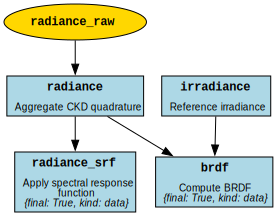

In [14]:
pipeline.visualize()